In [1]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
#from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from PIL import Image
import wandb
from evaluate import evaluate
from unet import UNet
#from utils.data_loading import BasicDataset, CarvanaDataset
from utils.dice_score import dice_loss
import numpy as np
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
image_size = 256

In [2]:

#from functools import lru_cache
#from functools import partial
#from itertools import repeat
#from multiprocessing import Pool

#from tqdm import tqdm


def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)


def unique_mask_values(idx, mask_dir, mask_suffix):
    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')
class BasicDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        self.data = torch.zeros(len(self.ids),image_size,image_size,3)
        self.mask = torch.zeros(len(self.ids),image_size,image_size)
        for idx, name in enumerate(self.ids):
            #name = self.ids[idx]
            mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
            img_file = list(self.images_dir.glob(name + '.*'))
            mask_file.sort()
            img_file.sort()
            assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
            assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
            mask = np.array(load_image(mask_file[0]))
            mask[np.where(mask!=0)]=1
            mask = mask[:,:,0].astype(np.uint8)
            img = np.asarray(load_image(img_file[0]))
            
            self.data[idx]=torch.tensor(img,dtype=torch.float32).contiguous()
            self.mask[idx]=torch.tensor(mask,dtype=torch.int).contiguous()

    def __len__(self):
        return len(self.ids)
    


    def process():
        pass

        
    

In [3]:
dir_img = Path('./data/imgs/')
dir_mask = Path('./data/masks/')
dir_checkpoint = Path('./checkpoints/')

In [4]:
dataset = BasicDataset(dir_img, dir_mask, 1)

In [5]:
dataset.mask[0].shape

torch.Size([256, 256])

In [6]:
num_data=dataset.data.shape[0]
val_percent= 0.1
num_val=int(num_data*val_percent)
num_train=num_data-num_val
list = [i for i in range(num_data)]
train_ids=np.random.choice(list,size=num_train,replace=False)
val_ids=np.setdiff1d(list,train_ids)
train_ids=np.sort(train_ids)
val_ids=np.sort(val_ids)
train_data=torch.zeros(num_train,image_size,image_size,3)
train_mask=torch.zeros(num_train,image_size,image_size)
val_data=torch.zeros(num_val,image_size,image_size,3)
val_mask=torch.zeros(num_val,image_size,image_size)
for i in range(num_train):
    train_data[i]=dataset.data[train_ids[i]]
    train_mask[i]=dataset.mask[train_ids[i]]
for i in range(num_val):
    val_data[i]=dataset.data[val_ids[i]]
    val_mask[i]=dataset.mask[val_ids[i]]
train_data=train_data.permute(0,3,1,2)
val_data=val_data.permute(0,3,1,2)
all_data = dataset.data.permute(0,3,1,2)
all_mask = dataset.mask



    

In [7]:
epochs = 20
batch_size=256
learning_rate = 1e-5
val_percent= 0.1
save_checkpoint = True
img_scale = 0.5
amp = False
weight_decay = 1e-8
momentum = 0.999
gradient_clipping = 1.0
n_train = len(train_data)
n_val = len(val_data)
class args:
    epochs = 5
    batch_size = 1
    lr = 1e-5
    load = False
    scale = 0.5
    val = 10.0
    amp = False
    bilinear = False
    classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
model = model.to(memory_format=torch.channels_last)
experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )
optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()




Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anony-moose-378003133848583373. Use `wandb login --relogin` to force relogin


In [8]:
def train():
    for epoch in range(1, epochs + 1):
      
        model.train()
        epoch_loss = 0
        train_acc = []
        global_step = 0
        
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
                images, true_masks = train_data, train_mask

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                        train_accuracy = ((F.sigmoid(masks_pred.squeeze(1)) > 0.5).float() == true_masks).float().mean()

                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )
                        train_accuracy = (torch.argmax(masks_pred, dim=1) == true_masks).float().mean()

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()
                
                pbar.update(images.shape[0])
                global_step += 1
                train_acc = train_acc.append(train_accuracy.item())
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item(), 'accuracy (batch)': train_accuracy.item()})
                if train_accuracy >=0.99:
                    break
    return  train_acc, epoch_loss


In [9]:
train_acc, epoch_loss = train()

Epoch 20/20: 100%|██████████| 63/63 [01:11<00:00,  1.14s/img, accuracy (batch)=0.94, loss (batch)=0.355]


In [10]:
experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                   val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
        )


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
step,1
train loss,0.35466


In [11]:
from utils.dice_score import multiclass_dice_coeff, dice_coeff
def evaluate(net, device, amp):
    net.eval()
    num_val_batches = num_val
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        with tqdm(total=num_val_batches, desc='Validation round', unit='img', leave=False):
            image, mask_true = val_data, val_mask
            all_images, all_masks = all_data, all_mask
            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)
            all_images = all_images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            all_masks = all_masks.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)
            all_mask_pred = net(all_images)
            all_pred = all_mask_pred.argmax(dim=1)
            pred= mask_pred.argmax(dim=1)
            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)
                val_accuracy = (mask_pred == mask_true).float().mean()
    print(mask_pred.shape)
    net.train()
    return dice_score / max(num_val_batches, 1) , val_accuracy , mask_pred, mask_true, pred, all_pred, all_masks

In [12]:
dice_score, val_accuracy, mask_pred, mask_true,  pred, all_pred, all_masks = evaluate(model, device, amp)
print(f'Dice score: {dice_score.item():.3f}, Accuracy: {val_accuracy.item():.3f}')

torch.Size([7, 2, 256, 256])
Dice score: 0.005, Accuracy: 0.905


In [13]:


whole_image = np.zeros((7*256,2560))
whole_mask = np.zeros((7*256,2560))
line_mask = np.zeros((256,2560))
line_image = np.zeros((256,2560))
for i in range(0,7):
    for j in range(0,10):
        id = i*10+j
        line_image[:,j*256:(j+1)*256] = all_pred[id,:,:]
        line_mask[:,j*256:(j+1)*256] = all_masks[id,:,:]
    whole_image[i*256:(i+1)*256,:] = line_image
    whole_mask[i*256:(i+1)*256,:] = line_mask

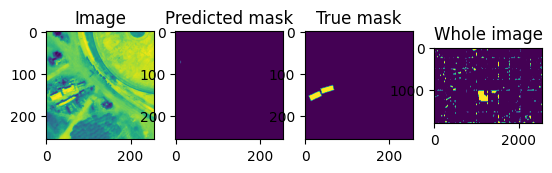

In [14]:
import matplotlib.pyplot as plt
plt.subplot(1, 4, 1)
image=val_data[3,:,:,:].cpu().numpy().transpose(1, 2, 0)
plt.imshow(image[:,:,0])
plt.title('Image')
plt.subplot(1, 4, 2)
result=mask_pred[3,1,:,:].cpu().numpy()
plt.imshow(result)
plt.title('Predicted mask')
plt.subplot(1, 4, 3)
plt.imshow(mask_true[3,1,:,:].cpu().numpy())
plt.title('True mask')
plt.subplot(1, 4, 4)
plt.imshow(whole_image)
plt.title('Whole image')

plt.show()



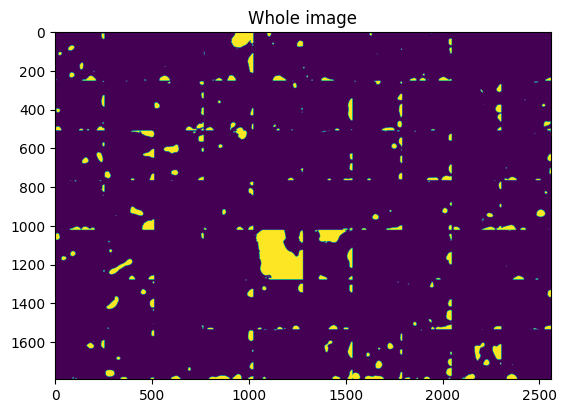

In [15]:

plt.imshow(whole_image)
plt.title('Whole image')

plt.show()

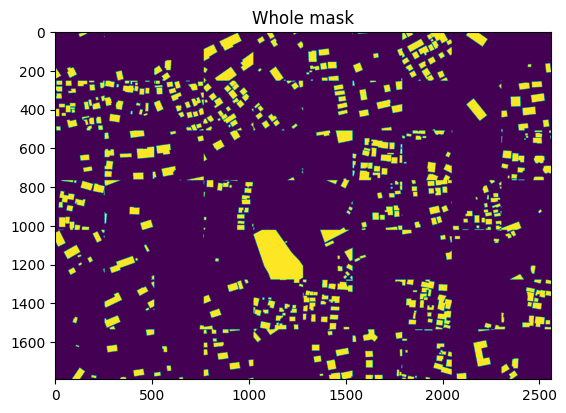

In [16]:

plt.imshow(whole_mask)
plt.title('Whole mask')

plt.show()